# Runner w. Machine Learning

This notebook shows how to perform a AlphaPept run with Machine Learning, using pDeep 3:

* Make sure the pdeep github repository is within the alphapept folder (https://github.com/pFindStudio/pDeep3)
* alphapept\pDeep3

In [ ]:
from time import time
%load_ext autoreload
%autoreload 2

In [ ]:
try:
    from pDeep3.pDeep.cmd.tune_and_predict import get_prediction  
except:
    raise ModuleNotFoundError('pdeeep not correctly installed')

C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-

tensorflow version = 1.13.1


## Logger

In [ ]:
import sys
import logging
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s %(levelname)-s - %(message)s', "%Y-%m-%d %H:%M:%S")
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

In [ ]:
#export
import logging

def check_enviroment():
    import numba 
    if float('.'.join(numba.__version__.split('.')[0:2])) < 0.46:
        raise RuntimeError('Numba version {} not sufficient'.format(numba.__version__))

def check_settings(settings):

    """
    Consistency check for settings.

    """
    check_enviroment()
    
    logging.info('Checking raw path {}.'.format(settings["raw"]["raw_path"]))

    #Check if a valid raw file is provided. If a npz file is also provided do not convert
    
    if os.path.isfile(settings["raw"]["raw_path_npz"]):
        logging.info('NPZ for raw file present. Skipping conversion step.')
        
        datatype = 'npz'
    else:
        if os.path.isfile(settings["raw"]["raw_path"]):
            logging.info('Found raw but no NPZ present. Performing conversion step.')
        elif os.path.isdir(settings["raw"]["raw_path"]):
            logging.info('Found raw but no NPZ present. Performing conversion step.')
        else:
            raise FileNotFoundError('Raw file {} and npz file {} not found'.format(settings['raw']['raw_path'], settings['raw']['raw_path_npz']))
            
            
    #check filetype -> todo what if we have an npz but no irignal file
    base, ext = os.path.splitext(settings["raw"]["raw_path"])
    
    if ext == '.raw':
        datatype='thermo'
        settings['search']['m_offset'] = 20
        settings['search']['m_tol'] = 20
    elif ext == '.d':
        datatype='bruker'
        settings['search']['m_offset'] = 50
        settings['search']['m_tol'] = 50
    else:
        raise NotImplementedError('File extension {} not understood.'.format(ext))

    logging.info('Raw path okay.')

    #Check library file
    logging.info('Checking library path.')

    if os.path.isfile(settings["fasta"]["library_path"]):
        logging.info('NPZ for library file present.')
        
        if settings["general"]["create_library"]:
            logging.info('Create_library set to True. Creating library from FASTA.')
    else:
        logging.info('No NPZ for library present. Creating library from FASTA.')
        settings["general"]["create_library"] = True
        

    logging.info('Library path okay.')
    
    
    settings['general']['type'] = datatype

    return settings

In [ ]:
from time import time
import numpy as np
from alphapept.runner import alpha_runner
from tqdm.notebook import tqdm as tqdm

from alphapept.settings import load_settings

settings = load_settings('default_settings.yaml')

settings['fasta']['library_path'] = 'F:/rawdata/zz.database/uniprot_Human_reviewed_March_2019_manual.npz'
settings['fasta']['fasta_path'] = 'F:/rawdata/zz.database/uniprot_Human_reviewed_March_2019_manual.fasta'
settings['fasta']['contaminants_path'] = 'F:/projects/alphapept/contaminants.fasta'

settings['raw']['raw_path_npz'] = 'F:/rawdata/04_hela_testrun/20190402_QX1_SeVW_MA_HeLa_500ng_LC11.npz'
settings['raw']['raw_path'] = 'F:/rawdata/04_hela_testrun/20190402_QX1_SeVW_MA_HeLa_500ng_LC11.raw'

settings['quantification']['max_lfq'] = False
settings['misc']['match_between_runs'] = False
settings['general']['find_features'] = False
settings['general']['create_library'] = False
settings['general']['convert_raw'] = False

settings['search']['calibrate'] = False

settings['general']['score'] = 'random_forest'


In [ ]:
"""
A wrapper function to run alphapept
"""
CURRENT_TASK = print
overall_progress = None
current_progress = None
import os

from functools import partial
import pandas as pd

#from alphapept.settings import check_settings

#assumes the dict is ordered 

time_dict = {}

timings = [10,15,20,20,20,15]
total_time = 0
for idx, element in enumerate(['library_generation', 'file_conversion', 'feature_finding', 'search', 'combining_files', 'reporting']):
    time_dict[element] = {}
    time_dict[element]['step'] = timings[idx]

    total_time += timings[idx]
    time_dict[element]['total'] = total_time


def check_time_dict(time_dict):
    """
    Function to check the validity of a time dict
    """

    total_time = 0

    for key in time_dict.keys():
        total_time += time_dict[key]['step']

    assert total_time == 100

check_time_dict(time_dict)

progress = 0

def progress_wrapper(current, delta=1):
    """
    Wrapper function to change the overall progress with the current progress
    """
    global progress

    if current_progress:
        current_progress(current)

    overall = progress + current*delta

    if overall_progress:
        overall_progress(overall)

    if current == 1.0:
        progress += delta

def set_progress(overall):
    global progress

    if overall_progress:
        overall_progress(overall)

    progress = overall


from alphapept.constants import mass_dict

CURRENT_TASK('Checking Settings')
settings = check_settings(settings)


### Library Generation ###

if settings["general"]["create_library"]:
    from alphapept.fasta import generate_library, generate_spectra, save_library

    te = time_dict['library_generation']['step']
    n_steps = 2

    CURRENT_TASK('Digesting FASTA')
    to_add, pept_dict, fasta_dict = generate_library(mass_dict, callback = partial(progress_wrapper, delta=1/n_steps*te), **settings['fasta'])
    logging.info('Digested {:,} proteins and generated {:,} peptides'.format(len(fasta_dict), len(to_add)))

    CURRENT_TASK('Generating Spectra')
    spectra = generate_spectra(to_add, mass_dict, callback = partial(progress_wrapper, delta=1/n_steps*te))
    logging.info('Generated {:,} spectra'.format(len(spectra)))

    CURRENT_TASK('Saving library')

    if settings['fasta']['library_path'] == '...':
        logging.info('Library path not set. Trying to create library path from fasta files.')

        if type(settings['fasta']['fasta_path']) is list:    
            base_names = [os.path.splitext(os.path.split(_)[1])[0] for _ in settings['fasta']['fasta_path']]
            base_path = os.path.split(settings['fasta']['fasta_path'][0])[0]
            #TODO: build in error check for too long paths
            settings['fasta']['library_path'] = os.path.join(base_path, '_'.join(base_names)+'.npz')

        else:
            base, ext = os.path.splitext(settings['fasta']['fasta_path'])
            settings['fasta']['library_path'] = base + '.npz'

        logging.info('Database path set to {}'.format(settings['fasta']['library_path']))

    library_path = save_library(spectra, pept_dict, fasta_dict, **settings['fasta'])             
    logging.info('Database saved to {}. Filesize {:.2f} Gb'.format(library_path, os.stat(library_path).st_size/(1024**3)))

set_progress(time_dict['library_generation']['total'])
### File Conversion ###

if settings["general"]["convert_raw"]:
    te = time_dict['file_conversion']['step']

    from alphapept.io import raw_to_npz

    CURRENT_TASK('Converting raw files')
    out_path = raw_to_npz(settings["raw"], callback=partial(progress_wrapper, delta=te))
    settings["raw"]["query_path"] = out_path[0]
    logging.info('Raw file(s) saved to {}'.format(out_path))
else:
    settings["raw"]["query_path"] = settings["raw"]["raw_path_npz"]

db_data = np.load(settings["fasta"]["library_path"], allow_pickle=True)
query_data = np.load(settings["raw"]["query_path"], allow_pickle=True)


set_progress(time_dict['file_conversion']['total'])

if settings["general"]["find_features"]:

    te = time_dict['feature_finding']['step']

    # === Parallelization of Fature Finding

    logging.info('Finding Features')

    if settings["general"]['type'] == 'thermo':

        n_steps = 8

        logging.info('Fature Finding for Thermo')
        #Feature Finding Part

        from alphapept.feature_finding import raw_to_centroid, get_hills, split_hills, filter_hills, get_hill_data, get_edges, get_isotope_patterns, feature_finder_report
        from alphapept.constants import averagine_aa, isotopes


        CURRENT_TASK('Converting centroids')
        centroids = raw_to_centroid(query_data, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('Loaded {:,} centroids.'.format(len(centroids)))

        CURRENT_TASK('Exctracting hills')
        completed_hills = get_hills(centroids, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('A total of {:,} hills extracted. Average hill length {:.2f}'.format(len(completed_hills), np.mean([len(_) for _ in completed_hills])))

        CURRENT_TASK('Splitting hills')
        splitted_hills = split_hills(completed_hills, centroids, smoothing=1, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('Split {:,} hills into {:,} hills'.format(len(completed_hills), len(splitted_hills)))

        CURRENT_TASK('Refining hills')
        filtered_hills = filter_hills(splitted_hills, centroids, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('Filtered {:,} hills. Remaining {:,} hills'.format(len(splitted_hills), len(filtered_hills)))

        CURRENT_TASK('Calculating hill statistics')
        sorted_hills, sorted_stats, sorted_data = get_hill_data(filtered_hills, centroids, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('Extracting hill stats complete')

        CURRENT_TASK('Connecting pre isotope patterns')
        pre_isotope_patterns = get_edges(sorted_stats, sorted_data, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('Found {} pre isotope patterns.'.format(len(pre_isotope_patterns)))

        CURRENT_TASK('Deisotope patterns')
        isotope_patterns, isotope_charges = get_isotope_patterns(pre_isotope_patterns, sorted_stats, sorted_data, averagine_aa, isotopes, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('Extracted {} isotope patterns.'.format(len(isotope_patterns)))

        CURRENT_TASK('Calculating feature statistics')
        feature_table = feature_finder_report(isotope_patterns, isotope_charges, sorted_stats, sorted_data, sorted_hills, query_data, callback=partial(progress_wrapper, delta=te*1/n_steps))
        logging.info('Report complete.')

    elif settings["general"]['type'] == 'bruker':

        logging.info('Fature Finding for Bruker')
        from alphapept.feature_finding import extract_bruker, convert_bruker

        feature_path = extract_bruker(settings['raw']['raw_path'])
        feature_table = convert_bruker(feature_path)

        logging.info('Extracted {:,} features.'.format(len(feature_table)))

    else:
        raise NotImplementedError('Filetype {} not understood.'.format(settings["general"]["type"]))

    from alphapept.feature_finding import map_ms2
    features = map_ms2(feature_table, query_data)

else:
    logging.info('Using Features from raw data')
    from alphapept.search import query_data_to_features
    features = query_data_to_features(query_data)


set_progress(time_dict['feature_finding']['total'])

### Search part ###

## The search is parallelized -> we can run this one after another.

# ==== Start looping through files

te = time_dict['search']['step']
n_steps = 2

from alphapept.search import get_psms, get_score_columns
from alphapept.score import score_x_tandem

CURRENT_TASK('Running first search.')
psms, num_specs_compared = get_psms(query_data, db_data, features, callback=partial(progress_wrapper, delta=te*1/n_steps), **settings["search"])
logging.info('First search complete. Compared {:,} spectra and found {:,} psms.'.format(num_specs_compared, len(psms)))

CURRENT_TASK('Extracting columns for scoring.')
psms, num_specs_scored = get_score_columns(psms, query_data, db_data, features, **settings["search"])
logging.info('Extracted columns for {:,} psms.'.format(num_specs_scored))


if settings['search']['calibrate']:
    CURRENT_TASK('Calibrating features.')

    CURRENT_TASK('Scoring psms.')
    df = score_x_tandem(pd.DataFrame(psms), plot=False, verbose=False, **settings["search"])
    logging.info('Scoring complete. For {} FDR found {:,} targets and {:,} decoys.'.format(settings["search"]["peptide_fdr"], df['target'].sum(), df['decoy'].sum()) )

    from alphapept.recalibration import get_calibration

    logging.info('Precursor Offset (PPM) is {:.2f} (mean), {:.2f} (std)'.format(df['o_mass_ppm'].mean(), df['o_mass_ppm'].std()))
    'Calibrating MS1 spectra'
    features_calib, df_sub = get_calibration(df, features, **settings["calibration"])

    o_mass_ppm_mean = df_sub['o_mass_ppm_calib'].mean()
    o_mass_ppm_std = df_sub['o_mass_ppm_calib'].std()

    logging.info('Calibration complete. Precursor Offset (PPM) is {:.2f} (mean), {:.2f} (std)'.format(o_mass_ppm_mean, o_mass_ppm_std))

    logging.info('Adjusting search bound to {:.2f} ppm.'.format(3*o_mass_ppm_std))

    settings["search"]["m_offset_calibrated"] = float(3*o_mass_ppm_std)

    CURRENT_TASK('Running second search.')
    psms, num_specs_compared = get_psms(query_data, db_data, features_calib, callback=partial(progress_wrapper, delta=te*1/n_steps), **settings["search"])
    logging.info('Second search complete. Compared {:,} spectra and found {:,} psms.'.format(num_specs_compared, len(psms)))

    CURRENT_TASK('Extracting columns for scoring.')
    psms, num_specs_scored = get_score_columns(psms, query_data, db_data, features_calib, **settings["search"])
    logging.info('Extracted columns for {:,} psms.'.format(num_specs_scored))


## Protein Groups and FDR control


set_progress(time_dict['search']['total'])

set_progress(time_dict['combining_files']['total'])

print('Complete')

F:\projects\alphapept\alphapept\constants.py:230: DeprecationWarning: invalid escape sequence \w
  protease_dict["asp-n"] = "\w(?=D)"
F:\projects\alphapept\alphapept\constants.py:232: DeprecationWarning: invalid escape sequence \w
  protease_dict["caspase 1"] = "(?<=[FWYL]\w[HAT])D(?=[^PEDQKR])"
F:\projects\alphapept\alphapept\constants.py:254: DeprecationWarning: invalid escape sequence \w
  protease_dict["ntcb"] = "\w(?=C)"
F:\projects\alphapept\alphapept\constants.py:255: DeprecationWarning: invalid escape sequence \w
  protease_dict["pepsin ph1.3"] = "((?<=[^HKR][^P])[^R](?=[FL][^P]))|((?<=[^HKR][^P])[FL](?=\w[^P]))"
F:\projects\alphapept\alphapept\constants.py:256: DeprecationWarning: invalid escape sequence \w
  protease_dict["pepsin ph2.0"] = "((?<=[^HKR][^P])[^R](?=[FLWY][^P]))|((?<=[^HKR][^P])[FLWY](?=\w[^P]))"
2020-06-26 10:45:50 INFO - Checking raw path F:/rawdata/04_hela_testrun/20190402_QX1_SeVW_MA_HeLa_500ng_LC11.raw.
2020-06-26 10:45:50 INFO - NPZ for raw file present. S

Checking Settings


C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-packages\biopython-1.76-py3.7-win-amd64.egg\Bio\Alphabet\__init__.py:26: PendingDeprecationWarning: We intend to remove or replace Bio.Alphabet in 2020, ideally avoid using it explicitly in your code. Please get in touch if you will be adversely affected by this. https://github.com/biopython/biopython/issues/2046
  PendingDeprecationWarning)
C:\Users\admin\.conda\envs\alphapept_pdeep\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\admin\.conda\envs\alphapept_pdeep\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\admin\.conda\envs\alphapept_pdeep\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary inco

Running first search.


2020-06-26 10:46:29 INFO - First search complete. Compared 59,901,139 spectra and found 257,566 psms.


Extracting columns for scoring.


2020-06-26 10:47:24 INFO - Extracted columns for 257,566 psms.


Complete


## Prediction Part
* Use sequences and charges from psms
* modifications are not considered yet

In [ ]:
from pDeep3.pDeep.cmd.tune_and_predict import get_prediction
df = pd.DataFrame(psms)
from alphapept.score import get_ML_features
df = get_ML_features(df, **settings['fasta'])

seqs = df['naked_sequence'].values
charges = df['charge'].values.astype('int')
mods = ['' for _ in range(len(charges))]

tuple_list = list(zip(seqs, mods, charges))

input_peptides = tuple_list
ion_types = ['b','y']
prediction = get_prediction(input_peptides) # no fine-tuning
ion_indices, used_ion_types = prediction.GetIonTypeIndices(ion_types)

2020-06-26 10:47:25 INFO - Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-06-26 10:47:25 INFO - NumExpr defaulting to 8 threads.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


2020-06-26 10:47:31 WARNING - From C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-packages\tensorflow\python\training\saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from F:/projects/alphapept/pDeep3/tmp/model/pretrain-180921-modloss-mod8D.ckpt


2020-06-26 10:47:31 INFO - Restoring parameters from F:/projects/alphapept/pDeep3/tmp/model/pretrain-180921-modloss-mod8D.ckpt


INFO:tensorflow:Restoring parameters from F:/projects/alphapept/pDeep3/tmp/model/RT-model.ckpt


2020-06-26 10:47:31 INFO - Restoring parameters from F:/projects/alphapept/pDeep3/tmp/model/RT-model.ckpt


[pDeep Info] loading peptides ...
[pDeep Info] predicting ...
[pDeep Info] predicted 212499 peptide precursors using 203.267 seconds
[pDeep Info] predicting time = 203.269s
[pDeep Info] predicting RT ...
[pDeep Info] predicted 212499 peptide precursors (RT) using 63.415 seconds
[pDeep Info] predicting time = 63.417s


## CCS prediction part

* one way would be to look up the sequence and then add the predicted ccs values

## Changes to db data

* create a list with db_intensities that can be used in search.py
* in search.py, we use the function intensity_product
* the funtioin intensity_product uses the following formula: matched_intensity = np.sum(matched_query_int*matched_db_int)
* this is potentially not beneficial as high intensity ions will dominate, maybe the log of the ratios would be better

In [ ]:
db_data_old = db_data

db_data = {}

for _ in db_data_old.files:
    
    db_data[_] = db_data_old[_]
    
from alphapept.fasta import get_fragmass, parse
from alphapept.constants import mass_dict

db_data = {}

for _ in db_data_old.files:
    
    db_data[_] = db_data_old[_]
    
    
from tqdm import tqdm as tqdm
db_ints = []

for _ in tqdm(input_peptides):
    
    fragmasses, fragtypes = get_fragmass(parse(_[0]), mass_dict)
    sortindex = np.argsort(fragmasses) #b then y
    
    n_idx = int(len(fragmasses)/2)
    
    b_ = np.zeros(n_idx)
    y_ = np.zeros(n_idx)
    
    pred = prediction.GetIntensitiesByIndices(*_, ion_indices)
    
    b_[:len(pred[:,0])] = pred[:,0]
    y_[:len(pred[:,2])] = pred[:,2]
    
    db_ints.append(np.array([b_,y_]).flatten()[sortindex])
    
db_data['db_ints'] = db_ints

100%|███████████████████████████████████████████████████████████████████████| 257566/257566 [00:18<00:00, 13881.70it/s]


In [ ]:
CURRENT_TASK('Extracting columns for scoring.')
psms, num_specs_scored = get_score_columns(psms, query_data, db_data, features, **settings["search"])
logging.info('Extracted columns for {:,} psms.'.format(num_specs_scored))

Extracting columns for scoring.


C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-packages\numba-0.48.0-py3.7-win-amd64.egg\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'db_ints' of function 'score_parallel'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "alphapept\search.py", line 474:
@njit(parallel=True)
def score_parallel(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\admin\.conda\envs\alphapept_pdeep\lib\site-packages\numba-0.48.0-py3.7-win-amd64.egg\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'db__ints' of function '__numba_parfor_gufunc_0x1b20eedafc8'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.htm

Scoring


F:\projects\alphapept\alphapept\score.py:197: RuntimeWarning: divide by zero encountered in log
  x_tandem = np.log(b.astype('float')*y.astype('float')*df['matched_int'].values)


57,609 target (576 decoy) of 74953 PSM. fdr 0.009998 for a cutoff of 19.64 


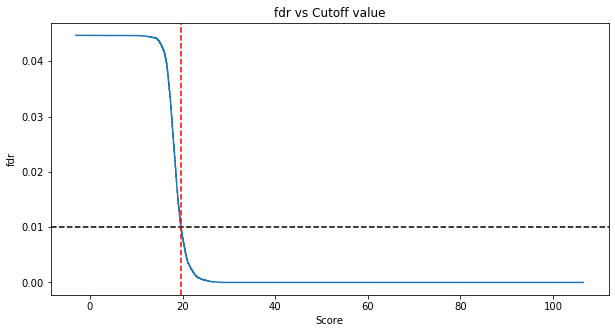

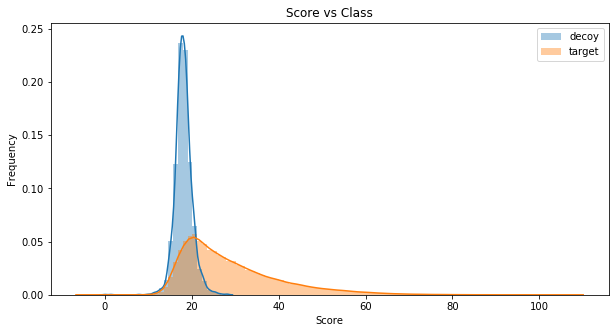

2020-06-26 10:53:58 INFO - First FDR Cut Scoring peptides complete. For 0.01 FDR found 57,609 targets and 576 decoys.


FDR control on peptides
49,163 target (491 decoy) of 50627 PSM. fdr 0.009987 for a cutoff of 19.89 


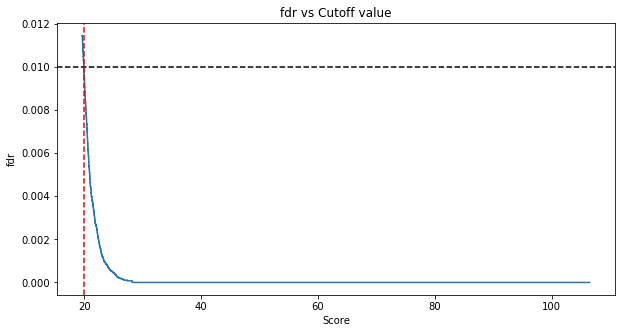

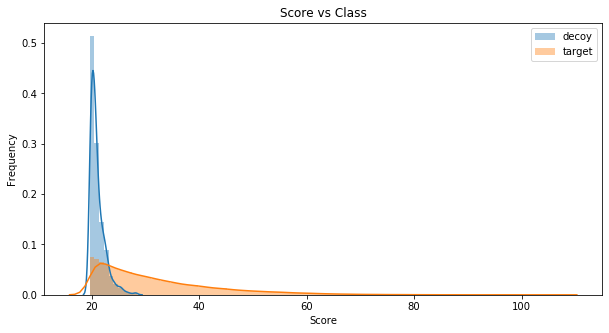

2020-06-26 10:53:59 INFO - Scoring peptides complete. For 0.01 FDR found 56,717 targets and 493 decoys.


Perform protein grouping
6,025 target (60 decoy) of 7846 PSM. fdr 0.009959 for a cutoff of 22.76 


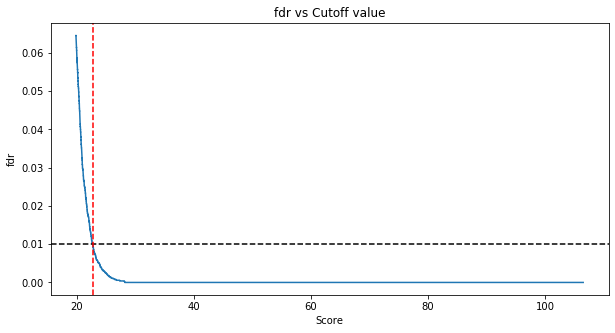

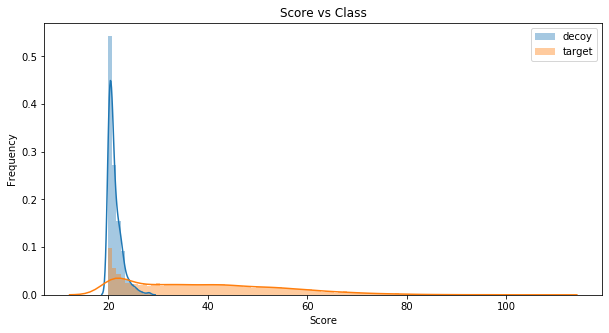

2020-06-26 10:54:27 INFO - Scoring proteins complete. For 0.01 FDR found 55,177 targets and 68 decoys. A total of 6,062 proteins found.


Saving.


2020-06-26 10:54:29 INFO - Saved to F:/rawdata/04_hela_testrun/20190402_QX1_SeVW_MA_HeLa_500ng_LC11_ap.csv
2020-06-26 10:54:29 INFO - Settings saved to F:/rawdata/04_hela_testrun/20190402_QX1_SeVW_MA_HeLa_500ng_LC11_ap_ml.yaml


Complete.


In [ ]:
import matplotlib
%matplotlib inline

from alphapept.score import cut_global_fdr, perform_protein_grouping, cut_global_fdr, get_x_tandem_score, filter_score, cut_fdr

CURRENT_TASK('Scoring')

settings["general"]["score"] = 'x_tandem'
df = pd.DataFrame(psms)

from alphapept.score import get_ML_features

df = get_ML_features(df, **settings['fasta'])

if settings["general"]["score"] == 'random_forest':
    from alphapept.score import train_RF, score_ML
    cv = train_RF(df)
    df = score_ML(df, cv)
elif settings["general"]["score"] == 'x_tandem':
    from alphapept.score import score_x_tandem
    df = score_x_tandem(df)
else:
    raise NotImplementedError('Scoring method {} not implemented.'.format(settings["general"]["score"]))
#df = cut_fdr(df, fdr_level=0.01, plot=False, verbose=False)
logging.info('First FDR Cut Scoring peptides complete. For {} FDR found {:,} targets and {:,} decoys.'.format(settings["search"]["peptide_fdr"], df['target'].sum(), df['decoy'].sum()) )


# ==== End looping through files and collection of dataframes
CURRENT_TASK('FDR control on peptides')
df = cut_global_fdr(df, analyte_level='sequence',  plot=True, verbose=True)
logging.info('Scoring peptides complete. For {} FDR found {:,} targets and {:,} decoys.'.format(settings["search"]["peptide_fdr"], df['target'].sum(), df['decoy'].sum()) )

CURRENT_TASK('Perform protein grouping')
df = perform_protein_grouping(df, db_data['pept_dict'].item(), db_data['fasta_dict'].item())
df = cut_global_fdr(df, analyte_level='protein',  plot=True, verbose=True)
logging.info('Scoring proteins complete. For {} FDR found {:,} targets and {:,} decoys. A total of {:,} proteins found.'.format(settings["search"]["protein_fdr"], df['target'].sum(), df['decoy'].sum(), len(set(df['protein']))))

## Quantification
if settings["quantification"]["max_lfq"]:
    raise NotImplementedError("MaxLFQ not implemented yet.")

## Misc
if settings["misc"]["match_between_runs"]:
    raise NotImplementedError("Match beween runs not implemented yet.")

CURRENT_TASK('Saving.')

base, ext = os.path.splitext(settings['raw']['query_path'])
out_path = base+'_ap.csv'
df.to_csv(out_path, index = False)
logging.info('Saved to {}'.format(out_path))

import yaml

out_path_settings = base+'_ap_ml.yaml'

with open(out_path_settings, 'w') as file:
    yaml.dump(settings, file)

logging.info('Settings saved to {}'.format(out_path_settings))

set_progress(time_dict['reporting']['total'])

CURRENT_TASK('Complete.')